In [266]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [291]:
df = pd.read_csv('Casos_positivos_de_COVID-19_en_Colombia.csv')
drop_columns = ["Código DIVIPOLA departamento", "Nombre departamento", "Código DIVIPOLA municipio",
            "Unidad de medida de edad", "Pertenencia étnica", "Nombre del grupo étnico"]
df = df.drop(columns=drop_columns)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71142 entries, 0 to 71141
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   fecha reporte web            71142 non-null  object 
 1   ID de caso                   71142 non-null  int64  
 2   Fecha de notificación        71142 non-null  object 
 3   Nombre municipio             71142 non-null  object 
 4   Edad                         71142 non-null  int64  
 5   Sexo                         71142 non-null  object 
 6   Tipo de contagio             71142 non-null  object 
 7   Ubicación del caso           70836 non-null  object 
 8   Estado                       70836 non-null  object 
 9   Código ISO del país          17 non-null     float64
 10  Nombre del país              17 non-null     object 
 11  Recuperado                   70860 non-null  object 
 12  Fecha de inicio de síntomas  70576 non-null  object 
 13  Fecha de muerte 

/home/jc/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [292]:
# Transform dates to datetime objects using the propper format
fechas = ["fecha reporte web", "Fecha de notificación", "Fecha de inicio de síntomas", "Fecha de muerte", "Fecha de diagnóstico", "Fecha de recuperación"]
f = ["f_reporte_web", "f_notificacion", "f_ini_sintomas", "f_muerte", "f_diagnostico", "f_recuperacion"]

for i in range(len(fechas)):
    print(fechas[i], "\t\t--->", f[i])
    df[f[i]] = pd.to_datetime( df[fechas[i]], format='%d/%m/%Y %H:%M:%S' )

df = df.drop(columns=fechas)
print("\n")
print(df.info())

fecha reporte web 		---> f_reporte_web
Fecha de notificación 		---> f_notificacion
Fecha de inicio de síntomas 		---> f_ini_sintomas
Fecha de muerte 		---> f_muerte
Fecha de diagnóstico 		---> f_diagnostico
Fecha de recuperación 		---> f_recuperacion


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71142 entries, 0 to 71141
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   ID de caso            71142 non-null  int64         
 1   Nombre municipio      71142 non-null  object        
 2   Edad                  71142 non-null  int64         
 3   Sexo                  71142 non-null  object        
 4   Tipo de contagio      71142 non-null  object        
 5   Ubicación del caso    70836 non-null  object        
 6   Estado                70836 non-null  object        
 7   Código ISO del país   17 non-null     float64       
 8   Nombre del país       17 non-null     object        


In [413]:
tibana = df[df['Nombre municipio'] == "TIBANA"]
tibana.head()

,ID de caso,Nombre municipio,Edad,Sexo,Tipo de contagio,Ubicación del caso,Estado,Código ISO del país,Nombre del país,Recuperado,Tipo de recuperación,f_reporte_web,f_notificacion,f_ini_sintomas,f_muerte,f_diagnostico,f_recuperacion
462,136252,TIBANA,37,M,En estudio,Casa,Leve,NaN,NaN,Recuperado,PCR,2020-07-10,2020-06-30,2020-06-26,NaT,2020-07-10,2020-07-21
541,175285,TIBANA,57,F,Relacionado,Casa,Leve,NaN,NaN,Recuperado,Tiempo,2020-07-17,2020-07-11,2020-07-11,NaT,2020-07-16,2020-08-09
543,175303,TIBANA,40,M,Relacionado,Casa,Leve,NaN,NaN,Recuperado,Tiempo,2020-07-17,2020-07-11,2020-07-11,NaT,2020-07-16,2020-08-09
544,175304,TIBANA,48,M,Relacionado,Casa,Leve,NaN,NaN,Recuperado,Tiempo,2020-07-17,2020-07-11,2020-07-11,NaT,2020-07-16,2020-08-09
545,175308,TIBANA,3,M,Relacionado,Casa,Leve,NaN,NaN,Recuperado,Tiempo,2020-07-17,2020-07-11,2020-07-11,NaT,2020-07-16,2020-08-09


Recuperado    146
Activo         13
Fallecido       2
Name: Recuperado, dtype: int64
1.0    146
0.0     15
Name: Recuperado, dtype: int64


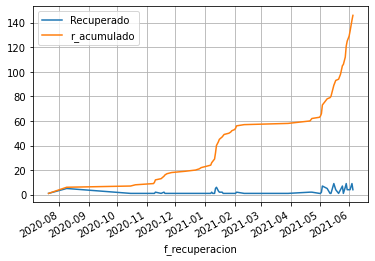

In [414]:
print(tibana['Recuperado'].value_counts())
tibana = tibana.replace({'Recuperado':1, 'Activo':0, 'Fallecido':0})
print(tibana['Recuperado'].value_counts())

recuperados = tibana.pivot_table(index="f_recuperacion", values="Recuperado",aggfunc=np.count_nonzero)
recuperados = recuperados.sort_index(ascending=True)
recuperados["r_acumulado"] = recuperados.cumsum()
recuperados.plot()
plt.grid()

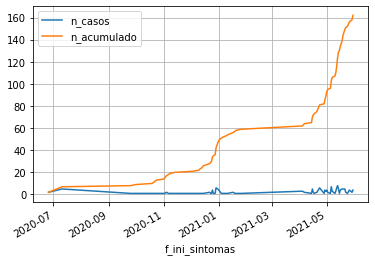

In [415]:
nuevosC = tibana.pivot_table(index="f_ini_sintomas", values="ID de caso",aggfunc=np.count_nonzero)
nuevosC = nuevosC.sort_index(ascending=True)
nuevosC["n_acumulado"] = nuevosC.cumsum()
nuevosC = nuevosC.rename(columns={"ID de caso":"n_casos"})
nuevosC.plot()
plt.grid()

In [416]:
d_min = min([nuevosC.index.min(), recuperados.index.min()])
d_max = max([nuevosC.index.max(), recuperados.index.max()])
t_index = pd.date_range(start=d_min, end=d_max, freq='D')
print(d_min, d_max, sep="\n")

2020-06-26 00:00:00
2021-06-05 00:00:00


In [417]:
nuevosC_r = nuevosC.reindex(t_index).pad().fillna(0)
recuperados_r = recuperados.reindex(t_index).pad().fillna(0)
casos_n_r = pd.concat([nuevosC_r, recuperados_r], axis=1)
casos_n_r['activos'] = casos_n_r['n_acumulado'] - casos_n_r['r_acumulado'] 
casos_n_r.head()

,n_casos,n_acumulado,Recuperado,r_acumulado,activos
2020-06-26,2.0,2.0,0.0,0.0,2.0
2020-06-27,2.0,2.0,0.0,0.0,2.0
2020-06-28,2.0,2.0,0.0,0.0,2.0
2020-06-29,2.0,2.0,0.0,0.0,2.0
2020-06-30,2.0,2.0,0.0,0.0,2.0


r_acumulado    146.0
activos         16.0
Name: 2021-06-05 00:00:00, dtype: float64


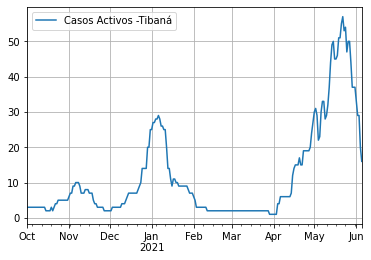

In [435]:
casos_n_r.loc[casos_n_r.index >= "2020-10-01","activos"].plot(label='Casos Activos -Tibaná')
plt.legend()
plt.grid()
plt.savefig('casos_activos_Tibana.png')
print(casos_n_r.iloc[-1,[-2,-1]])

# Carpentry

In [94]:
towns = ["BOYACA","CIENEGA", "JENESANO", "NUEVO COLON", "RAMIRIQUI", "TIBANA", "RONDON", "TURMEQUE", "UMBITA", "VIRACACHA"]
marquez = df[ df["Nombre municipio"].isin(towns) ]
marquez.groupby("Nombre municipio")["ID de caso"].agg(np.count_nonzero)

Nombre municipio
BOYACA          65
CIENEGA         39
JENESANO        90
NUEVO COLON     49
RAMIRIQUI      339
RONDON           4
TIBANA         162
TURMEQUE       116
UMBITA          79
VIRACACHA       26
Name: ID de caso, dtype: int64